# Running and Plotting Coeval Cubes

The aim of this tutorial is to introduce you to how `21cmFAST` does the most basic operations: producing single coeval cubes, and visually verifying them. It is a great place to get started with `21cmFAST`.

In [8]:
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging

import matplotlib.pyplot as plt

logger = logging.getLogger("py21cmfast")
logger.setLevel(logging.INFO)

from tempfile import mkdtemp

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

In [9]:
print(f' Using 21cmFAST version {p21c.__version__}')

 Using 21cmFAST version 4.0.0b1.dev312+gb6f5204f.d20250728


## Run a simulation using `run_coeval` and `generate_coeval`

Specifying input parameters is a topic covered in a [different tutorial](defining_input_params.html).
Here, we want something small and fast:

In [10]:
inputs = p21c.InputParameters.from_template(
    ["simple", 'small'], random_seed=1234
)

The simplest (and typically most efficient) way to produce a coeval cube is simply to 
use the `run_coeval` method. This consistently performs all steps of the calculation, 
re-using any data that it can without re-computation or increased memory overhead.

First we make a temporary cache to store our fields, in larger runs 21cmFAST can store its outputs in an `OutputCache` to avoid unnecessary regeneration

In [11]:
cache = p21c.OutputCache(mkdtemp())

In [12]:
coevals = p21c.run_coeval(
    inputs=inputs,
    out_redshifts=[8, 9, 10],
    cache=cache,
    progressbar=True
)

Output()

Output()

The `generate_coeval` method is a generator, which can be called as follows:

In [13]:
coevals = []
for coeval,in_outputs in p21c.generate_coeval(
    inputs=inputs,
    out_redshifts=[8, 9, 10],
    cache=cache,
):
    if in_outputs:
        coevals.append(coeval)
        

Note that this run was much faster, since we cached the outputs from the previous run, and they were simply loaded instead of re-calculated

There are a number of possible inputs for `generate/run_coeval`, which you can check out either in the [API reference](../reference/py21cmfast.html) or by calling `help(p21c.run_coeval)`. 

Notably, in our case here, the `out_redshifts` must be given: these are the redshifts
at which we compute the coeval boxes. When the simulation requires evolution over 
cosmic history, coeval boxes will be computed at every node _as well as_ any 
`out_redshifts` specified. 

Since the function is a generator, it yields a `Coeval` box on each iteration. These
boxes can be saved or post-processed before completing the next iteration, allowing
arbitrarily flexible computations to be performed. The second returned values is a 
boolean which tells you whether you are at a requested output point in `out_redshifts`.

We've also given a `cache` parameter: this specifies a directory in which the various
component calculations of this simulation will be cached. By default, this will occur
in the current directory, but here we are using a temporary directory for convenience.
While by default all sub-components are written into the cache, this can be turned off
altogether, or toggled per subcomponent. The main reason to use the cache is if you 
might want to re-use simulated component boxes in other simulations in the future.
A prime example of this is the `InitialConditions`, for which a single simulation can
be used for a multitude of astrophysical simulations with varying `AstroParams`. 

The output on each iteration is, as we have mentioned, a `Coeval` object. This is a simple
object that contains a number of 3D arrays of data, one for each of the component fields
simulated. They can be accessed as attributes of the object:

In [14]:
coevals[0].redshift

10.0

A list of all simulated fields can be accessed:

In [15]:
coevals[0].get_fields()

['lowres_density',
 'lowres_vx',
 'lowres_vy',
 'lowres_vz',
 'hires_density',
 'hires_vx',
 'hires_vy',
 'hires_vz',
 'lowres_vx_2LPT',
 'lowres_vy_2LPT',
 'lowres_vz_2LPT',
 'hires_vx_2LPT',
 'hires_vy_2LPT',
 'hires_vz_2LPT',
 'lowres_vcb',
 'density',
 'velocity_z',
 'velocity_x',
 'velocity_y',
 'neutral_fraction',
 'ionisation_rate_G12',
 'mean_free_path',
 'z_reion',
 'cumulative_recombinations',
 'kinetic_temperature',
 'unnormalised_nion',
 'unnormalised_nion_mini',
 'brightness_temp',
 'tau_21',
 'spin_temperature',
 'xray_ionised_fraction',
 'kinetic_temp_neutral',
 'J_21_LW',
 'halo_mass',
 'halo_stars',
 'halo_stars_mini',
 'count',
 'halo_sfr',
 'halo_sfr_mini',
 'halo_xray',
 'n_ion',
 'whalo_sfr']

The `Coeval` object also maintains a reference to the input parameters:

In [16]:
coevals[0].inputs

cosmo_params: CosmoParams(SIGMA_8=0.8102, hlittle=0.6766, OMm=0.30964144154550644, OMb=0.04897468161869667, POWER_INDEX=0.9665, OMn=0.0, OMk=0.0, OMr=8.6e-05, OMtot=1.0, Y_He=0.24, wl=-1.0)
simulation_options: SimulationOptions(HII_DIM=64, _BOX_LEN=None, _DIM=None, _HIRES_TO_LOWRES_FACTOR=None, _LOWRES_CELL_SIZE_MPC=None, NON_CUBIC_FACTOR=1.0, N_THREADS=1, SAMPLER_MIN_MASS=100000000.0, SAMPLER_BUFFER_FACTOR=2.0, N_COND_INTERP=200, N_PROB_INTERP=400, MIN_LOGPROB=-12.0, HALOMASS_CORRECTION=0.89, PARKINSON_G0=1.0, PARKINSON_y1=0.0, PARKINSON_y2=0.0, Z_HEAT_MAX=35.0, ZPRIME_STEP_FACTOR=1.1, INITIAL_REDSHIFT=300.0, DELTA_R_FACTOR=1.1, DENSITY_SMOOTH_RADIUS=0.2, DEXM_OPTIMIZE_MINMASS=100000000000.0, DEXM_R_OVERLAP=2.0, CORR_STAR=0.5, CORR_SFR=0.2, CORR_LX=0.2)
matter_options: MatterOptions(HMF='ST', USE_RELATIVE_VELOCITIES=False, POWER_SPECTRUM='EH', PERTURB_ON_HIGH_RES=False, USE_INTERPOLATION_TABLES='hmf-interpolation', MINIMIZE_MEMORY=False, KEEP_3D_VELOCITIES=False, SAMPLE_METHOD='MASS-L

We can also save/load a Coeval object to disk:

In [17]:
coevals[0].save(cache.direc / "coeval.h5")

Note that, if you are also using the cache (as we are), then saving the `Coeval` object
creates redundant data on disk. The files created by `Coeval` are more convenient for 
saving, sharing and using in further post-processing, but are not easily used for 
caching purposes.

The file that we wrote can be easily read:

In [18]:
coeval10 = p21c.Coeval.from_file(cache.direc / "coeval.h5")

Some convenient plotting functions exist in the `plotting` module. These can work directly on `Coeval` objects, or any of the output structs (as we'll see further on in the tutorial). By default the `coeval_sliceplot` function will plot the `brightness_temp`, using the standard traditional colormap:

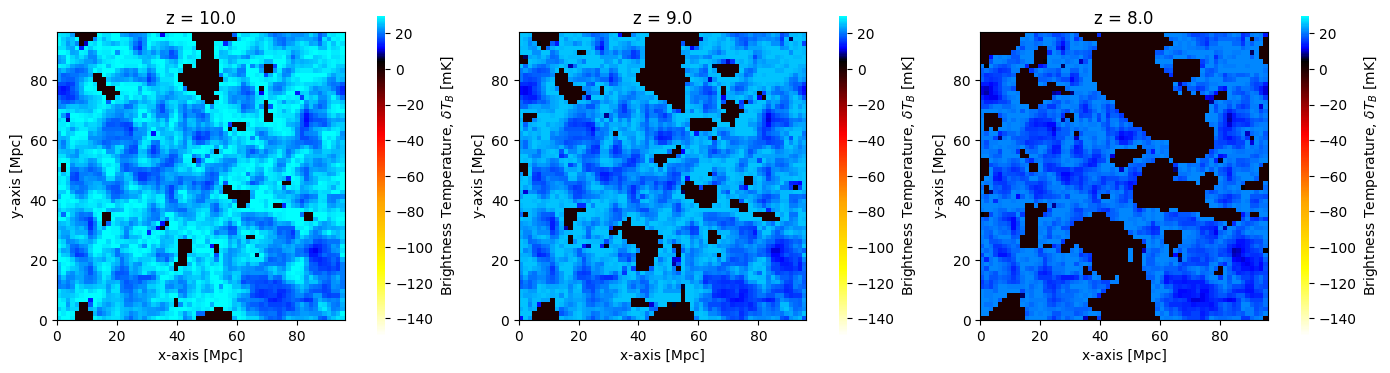

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, coeval in enumerate(coevals):
    plotting.coeval_sliceplot(coeval, ax=ax[i], fig=fig)
    plt.title(f"z = {coeval.redshift}")
plt.tight_layout()

Any 3D field can be plotted, by setting the `kind` argument. For example, we could alternatively have plotted the dark matter density cubes perturbed to each redshift:

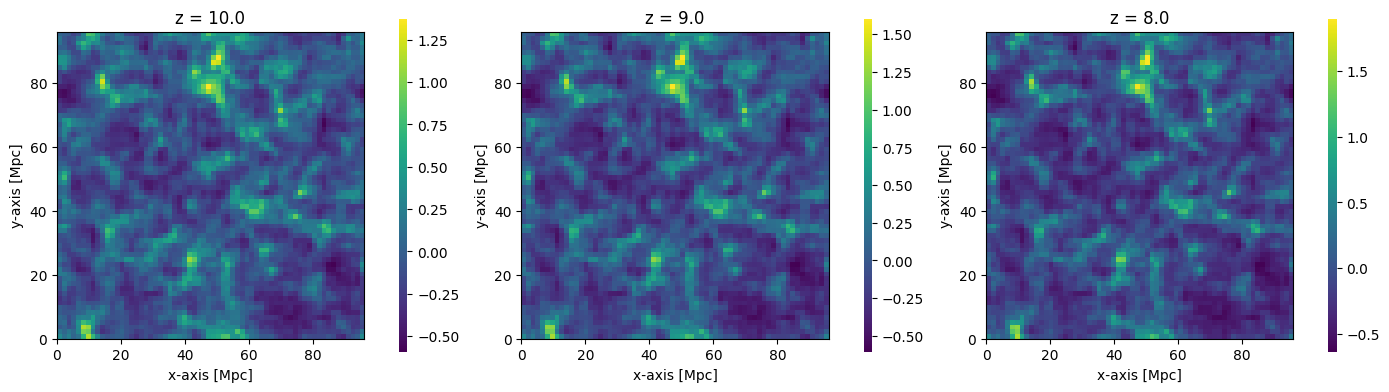

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, coeval in enumerate(coevals):
    plotting.coeval_sliceplot(coeval, kind="density", ax=ax[i], fig=fig)
    plt.title(f"z = {coeval.redshift}")
plt.tight_layout()

To see more options for the plotting routines, see the [API Documentation](../reference/_autosummary/py21cmfast.plotting.html).

This brief example covers most of the basic usage of `21cmFAST` (at least with `Coeval` objects -- there are also `Lightcone` objects for which there is a separate tutorial). 

For the rest of the tutorial, we'll cover a more advanced usage, in which each step of the calculation is done independently.

## Advanced Step-by-Step Usage

Most users most of the time will want to use the high-level `run_coeval` function from the previous section. However, there are several independent steps when computing the brightness temperature field, and these can be performed one-by-one, adding any other effects between them if desired. In this section, we'll go through in more detail how to use the lower-level methods.

Each step is performed by running a function which will return a single object. 
Every major function returns an object of the same fundamental class (an ``OutputStruct``) 
which has methods to share its underlying data with the backend C code, and maintain 
knowledge of the state of its memory.

As we move through each step, we'll outline some extra details, hints and tips about using these inputs and outputs.

The first thing to do is to set up the input parameters. Here, we'll use the same
basic set of parameters as we used in `run_coeval`, but with a different random seed, 
which ensures that we compute all new boxes.

In [21]:
new_inputs = inputs.clone(random_seed=42)

### Initial Conditions

The first step is to get the initial conditions, which defines the *cosmological* density field before any redshift evolution is applied.

In [22]:
initial_conditions = p21c.compute_initial_conditions(
    inputs=new_inputs, cache=cache, write=True
)

As we said, all of these "single field" functions return objects of type `OutputStruct`.
These objects have a few things in common. For example, they hold a reference to their
input parameters:

In [23]:
initial_conditions.inputs.simulation_options.HII_DIM

64

More importantly, once computed, they hold the simulated data. This data is held in 
special `Array` objects, and all the available simulated fields can be accessed through
the `.arrays` attribute:

In [24]:
initial_conditions.arrays.keys()

dict_keys(['lowres_density', 'lowres_vx', 'lowres_vy', 'lowres_vz', 'hires_density', 'lowres_vx_2LPT', 'lowres_vy_2LPT', 'lowres_vz_2LPT', 'hires_vx_2LPT', 'hires_vy_2LPT', 'hires_vz_2LPT'])

As we mentioned, the values of these attributes are _not_ numpy arrays, but custom
`Array` objects. These have the ability to track their state: whether they initialized,
computed, stored on disk, etc., and they also know how to share themselves with the 
C backend. While this is useful for the simulation, it is not that helpful to _you_ as 
a user. That's OK: these objects aren't really meant to be the primary way you interact
with `21cmFAST` as a user. 

However, to get at the underlying numpy array, you can use the `.get()` method:

In [25]:
initial_conditions.get("lowres_density").mean()

np.float32(0.00012248568)

This has the handy feature that even if the array has been purged from memory but stored
on disk, the `.get()` method will still return the array (it will read it from disk,
and store it back on the object until you tell the object to purge it again).

For example:

In [26]:
initial_conditions.purge()

Once purged, the array's state shows that it is not initialized or in memory, but it
is stored on disk (because we passed `write=True` when computing it):

In [27]:
initial_conditions.lowres_density.state

ArrayState(initialized=False, c_memory=False, computed_in_mem=False, on_disk=True)

However, when we use `.get()`, the array is re-loaded:

In [28]:
initial_conditions.get("lowres_density").mean()

np.float32(0.00012248568)

In [29]:
initial_conditions.lowres_density.state

ArrayState(initialized=True, c_memory=False, computed_in_mem=True, on_disk=True)

The `coeval_sliceplot` function also works on `OutputStruct` objects (as well as the `Coeval` object as we've already seen). It takes the object, and a specific field name. By default, the field it plots is the _first_ field in `arrays` (for any `OutputStruct`).

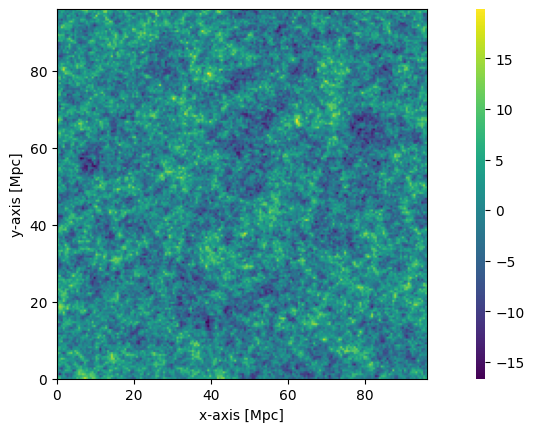

In [30]:
plotting.coeval_sliceplot(initial_conditions, "hires_density");

### Perturbed Field

After obtaining the initial conditions, we need to *perturb* the field to a given redshift (i.e. the redshift we care about). This step clearly requires the results of the previous step, which we can easily just pass in. Let's do that:

In [31]:
perturbed_field = p21c.perturb_field(
    redshift=8.0, initial_conditions=initial_conditions
)

Note that we didn't need to pass in any input parameters, because they are all contained in the `initial_conditions` object itself. The random seed is also taken from this object.

Again, the output is an `OutputStruct`, so we can view its fields:

In [32]:
perturbed_field.arrays.keys()

dict_keys(['density', 'velocity_z'])

This time, it has only density and velocity (the velocity direction is chosen without loss of generality). Let's view the perturbed density field:

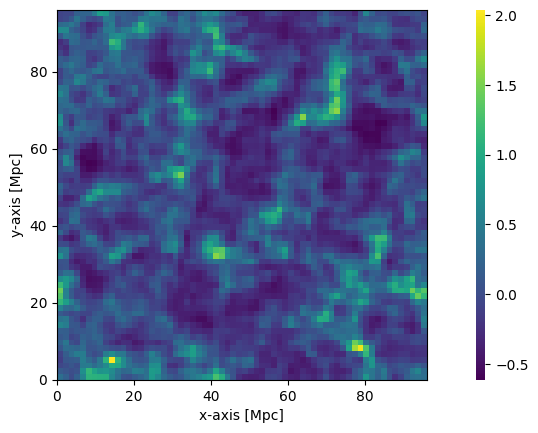

In [33]:
plotting.coeval_sliceplot(perturbed_field, "density");

It is clear here that the density used is the *low*-res density, but the overall structure of the field looks very similar.

### Ionization Field

Next, we need to ionize the box. This is where things get a little more tricky. 
In the simplest case we are using in this tutorial, the ionization occurs at the 
*saturated limit*, which means we can safely ignore the contribution of the spin 
temperature fluctuations. 
This means we can directly calculate the ionization on the density/velocity fields that 
we already have.

In [34]:
ionized_field = p21c.compute_ionization_field(
    initial_conditions=initial_conditions, perturbed_field=perturbed_field
)

Let's see the fieldnames:

In [35]:
ionized_field.arrays.keys()

dict_keys(['neutral_fraction', 'ionisation_rate_G12', 'mean_free_path', 'z_reion', 'kinetic_temperature', 'unnormalised_nion'])

Let's plot the neutral fraction:

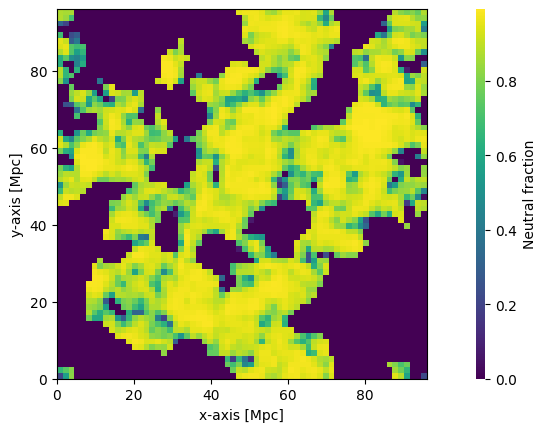

In [36]:
plotting.coeval_sliceplot(ionized_field, "neutral_fraction");

### Brightness Temperature

Now we can use what we have to get the brightness temperature:

In [37]:
brightness_temp = p21c.brightness_temperature(
    ionized_box=ionized_field, perturbed_field=perturbed_field
)

This has only a single field, ``brightness_temp``:

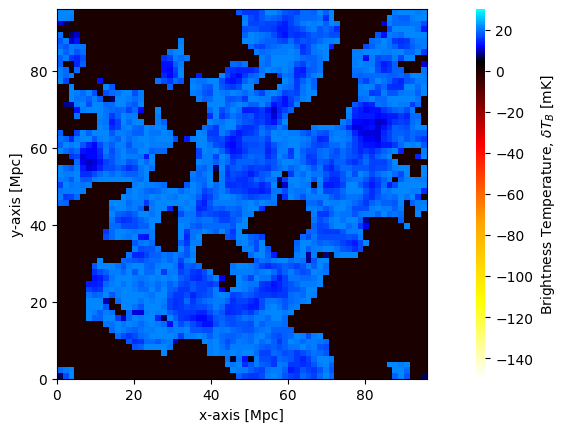

In [38]:
plotting.coeval_sliceplot(brightness_temp);